# RL Coursework 1

## Questions 1
a. Write out your personalised trace. Please use exactly the same format as in the example above.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

cid = 1349379
cid = [int(x) for x in str(cid)]

states = [np.mod((cid[t] + 2), 4) for t in range(len(cid))]
rewards = [np.mod((cid[t]), 4) for t in range(len(cid))]

trace = [None]*(len(states)+len(rewards))
trace[::2] = states
trace[1::2] = rewards


# Question 2

a. State your personalised reward state, p, and γ (1 pts)

In [4]:
class GridElement():
    def __init__(self, name=None, reward=None, location_coords=None, is_terminal=False, is_wall=False):
        self.location = location_coords
        self.reward = reward
        self.is_terminal = is_terminal
        self.is_wall = is_wall

    def __repr__(self):
        if self.is_wall:
            return '[ ]'
        return str(self.reward)
    
    def set_as_wall(self):
        self.is_wall = True
        return self

In [5]:
class NewGridWorld():
    def __init__(self, 
            absorbing_locs=None,
            special_rewards=None,
            p_transition=0.45,
            obstacle_locs=[(1,1), (2,3), (2, 5), (3,1), (4,1), (4,2), (4,4)],
            shape=(6,6)):
        self.reward_state_rew = reward_state_rew
        self.penalty_state_rew = penalty_state_rew

        ### Attributes defining the Gridworld #######
        # Shape of the gridworld
        self.shape = shape
        
        # Locations of the obstacles
        self.obstacle_locs = obstacle_locs
        self.absorbing_locs = absorbing_locs

        # Reward for all the other states
        self.default_reward = -1
        self.special_rewards = special_rewards

        # Starting location
        self.starting_loc = (1,0)
        
        # Action names
        self.action_names = {
            'North': 'N',
            'East': 'E',
            'South': 'S',
            'West': 'W'}
        self.action_names_list = ['N', 'E', 'S', 'W']
        self.action_size = len(self.action_names)
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [0.8, 0.1, 0.0 , 0.1]
        self.p_transition = p_transition

        # Measuring convergence via delta's
        self.delta_history = []
        
        ############################################


        #### Internal State  ####
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs, neighbors = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 22 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs

        # Neighbors
        self.neighbors = neighbors
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs)
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)))
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape)
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        # self.paint_maps()
        ################################


    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    ########################


    ####### Methods #########
    ##########################


    ############# PLOTTING AND DRAWING #############

    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers)
        # plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action = np.argmax(Policy[state, :])
            action = int(action)
            action_arrow = arrows[action]

            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center')
    
        plt.show()

    def draw_value(self, Value):
        # Draw a policy value function
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        plt.show()

    def draw_delta_history(self):
        # Draw the progression of deltas with each epoch
        fig = plt.figure()

        plt.plot(self.delta_history)
        plt.title('Value convergence')
        plt.xlabel('Epoch')
        plt.ylabel('Delta')
        plt.show()

    def draw_deterministic_policy_grid(self, Policy, titles, n_columns, n_lines):
        # Draw a grid of deterministic policy
        # The policy needs to be an arrya of np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20,8))
        for subplot in range (len(Policy)): # Go through all policies
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, action in enumerate(Policy[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                  continue
              arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
              action = np.argmax(action)
              action = int(action)
              action_arrow = arrows[action] # Take the corresponding action
              location = self.locs[state] # Compute its location on graph
              plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
          ax.title.set_text(titles[subplot]) # Set the title for the graoh given as argument
        plt.show()

    def draw_value_grid(self, Value, titles, n_columns, n_lines):
        # Draw a grid of value function
        # The value need to be an array of np array of 22 values 
        plt.figure(figsize=(20,8))
        for subplot in range (len(Value)): # Go through all values
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, value in enumerate(Value[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                  continue
              location = self.locs[state] # Compute the value location on graph
              plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
          ax.title.set_text(titles[subplot]) # Set the title for the graoh given as argument
        plt.show()
        

    ##########################
    
    
    ########### Internal Helper Functions #####################
    def paint_maps(self):
        # Helper function to print the grid word used in __init__
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.title('Obstacles')
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.title('Absorbing states')
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders)
        plt.title('Reward states')
        plt.show()

    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbors of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbors, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,self.action_size))

        # Possible probabilities of transitions
        self_prob = self.p_transition  # self.action_randomizing_array[effect]
        neighbor_prob = (1 - self.p_transition) / (self.action_size - 1)
        
        # To fill T, we need to check if the current action leads us to the
        # next state. 
        # For each prior state, choose an action, then assign probs to each post_state
        for prior_state in range(S):
            for action in range(self.action_size):
                for effect in range(self.action_size):
                    post_state = neighbors[prior_state, effect]
                    post_state = int(post_state)

                    # If this is the desired action
                    if action == effect:
                        T[post_state,prior_state,action] = self_prob
                    else:
                        T[post_state,prior_state,action] = neighbor_prob
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,self.action_size))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T,R,absorbing,locations, neighbors
    

    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbor_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbors of each state, in terms of locations
                    local_neighbors = [self.get_neighbor(loc,direction) for direction in list(self.action_names.values())]
                    neighbor_locs.append(local_neighbors)
                
        # translate neighbor lists from locations to states
        num_states = len(locs)
        state_neighbors = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbor location
                nloc = neighbor_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbor matrix
                state_neighbors[state,direction] = nstate
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbors, absorbing 


    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))

    def state_to_loc(self, state, locs):
        #convert given (valid) state number to its grid location
        return locs[state]

    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
            return True
            
    def get_neighbor(self,loc,direction):
        #Find the valid neighbors (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbor is a valid location, accept it, otherwise, stay put
        if(direction == self.action_names['North'] and self.is_location(nr)):
            return nr
        elif(direction == self.action_names['East'] and self.is_location(ea)):
            return ea
        elif(direction == self.action_names['South'] and self.is_location(so)):
            return so
        elif(direction == self.action_names['West'] and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc

    def states_to_direction(self, prior, post):
        """ Return the direction needed to go from prior state to post state.
        Aka the direction you are facing when going to post state from prior. """

        prior_loc = self.state_to_loc(prior, self.locs)
        post_loc = self.state_to_loc(post, self.locs)
        # print('prior_loc', prior_loc)
        # print('post_loc', post_loc)

        if prior_loc[0] < post_loc[0]:
            return self.action_names_list.index(self.action_names['North'])
        if prior_loc[1] < post_loc[1]:
            return self.action_names_list.index(self.action_names['East'])
        if prior_loc[0] > post_loc[0]:
            return self.action_names_list.index(self.action_names['South'])
        if prior_loc[1] > post_loc[1]:
            return self.action_names_list.index(self.action_names['West'])
        else:
            return np.random.randint(0, self.action_size)

    # def convert_index_to_loc(self, idx, row_num, col_num):
    #     row_idx = idx // row_num
    #     col_idx = idx % col_num
    #     return (row_idx, col_idx)

        
###########################################         

(array([0, 0]), array([ 7, 21]))

In [6]:
class DP_Policy_World(NewGridWorld):
    
    def __init__(self, 
            absorbing_locs=None,
            special_rewards=None,
            p_transition=0.45
            ):
        super(self.__class__, self).__init__(absorbing_locs, special_rewards, p_transition)

    ####### Methods #########
    def value_iteration(self, discount = 0.9, threshold = 0.0001):
        ## Slide 144 of the lecture notes for the algorithm ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        epochs = 0
        delta = threshold # Setting value of delta to go through the first breaking condition
        V = np.zeros(self.state_size) # Initialise values at 0 for each state

        while delta >= threshold:
            epochs += 1 # Increment the epoch
            delta = 0 # Reinitialise delta value

            # For each state
            for state_idx in range(self.state_size):

                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):
                  
                    # Store the previous value for that state
                    old_V = V[state_idx] 

                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(self.state_size):
                        current_return = R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime]
                        Q += T[state_idx_prime,state_idx,:] * current_return
                
                    # Set the new value to the maximum of Q
                    V[state_idx]= np.max(Q) 

                    # Compute the new delta
                    delta = max(delta, np.abs(old_V - V[state_idx]))
                    # delta = max(abs(Vnew-V))
            

        # When the loop is finished, fill in the optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size)) # Initialisation

        # For each state
        for state_idx in range(self.state_size):
            # If not an absorbing state
            if not(self.absorbing[0,state_idx]):

                # Compute Q value
                Q = np.zeros(4)
                for state_idx_prime in range(self.state_size):
                    Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                
                # The action that maximises the Q value gets probability 1
                optimal_policy[state_idx, np.argmax(Q)] = 1 

        return optimal_policy, V, epochs


    def policy_iteration(self, policy, discount=0.9, threshold = 0.0001):
        """ Policy Improvement / Iterative policy to get optimal value and policy. Full sweep. """
        epochs = [0]
        V = np.zeros(policy.shape[0])
        returns = [0]

        R = self.get_reward_matrix()
        T = self.get_transition_matrix()

        # Prepare plot
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # Ln = ax.plot(values)
        # ax.plot(returns)
        # ax.set_xlim([0,20])
        # plt.ion()
        # plt.imshow(self.walls+self.rewarders +self.absorbers)
        # plt.show()  

        is_policy_stable = False
        while (not is_policy_stable) and (epochs[-1] < 2000):
            is_policy_stable = True

            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)

            epochs.append(epochs[-1] + epochs_eval)
            returns.append(np.sum(V))
            print('Iteration Epochs:', epochs[-1])

            # Policy iteration
            for state_idx in range(policy.shape[0]):
                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):

                    # Store the old action
                    old_action = np.argmax(policy[state_idx,:])

                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(policy.shape[0]):
                        current_return = R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime]
                        Q += T[state_idx_prime,state_idx,:] * current_return

                    # Compute corresponding policy
                    new_policy = np.zeros(4)
                    new_policy[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
                    policy[state_idx] = new_policy
                    
                    if old_action != np.argmax(policy[state_idx]):
                        is_policy_stable = False

            ### PLOT V progress ###
            # ax.plot(returns, epochs)
            # self.draw_value(V)
            # Ln.set_ydata(values)
            # Ln.set_xdata(epochs)
            # plt.pause(1)

        # self.draw_value(V)
        # self.draw_deterministic_policy(policy)

        return V, policy, epochs


    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        # Measuring convergence via delta's
        self.delta_history = []
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)

        epoch = 0        
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1

            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    Q = 0
                    for state_idx_prime in range(policy.shape[0]):
                        Q += T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * Q
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta = max(abs(Vnew-V))
            self.delta_history.append(delta)
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch

    ##########################

In [7]:
cid_nums = 379
x = int(str(cid_nums)[0])
y = int(str(cid_nums)[1])
z = int(str(cid_nums)[2])

p = 0.25 + 0.5 * (x+1)/10
gamma = 0.2 + 0.5 * y/10
j = np.mod((z+1), 3) + 1

print("The value of p is {} and the value of gamma is {}".format(p, gamma))
print("The reward state is s_{}".format(j))


The value of p is 0.45 and the value of gamma is 0.55
The reward state is s_2


b. Dynamic Programming (with full world knowledge) (24 pts)

1. Compute the optimal value function and the optimal policy using Dynamic Programming.
Briefly state how you solved the problem, including any parameters that you set or assumptions you made.

In [8]:
# Creating GridWorld
reward_state_rew = ((1, 2), 10)     # State 2
penalty_state_rew = ((4, 3), -100)  # State 11

absorbing_locs = [reward_state_rew[0], penalty_state_rew[0]]
special_rewards = [reward_state_rew[1], penalty_state_rew[1]]

# p = 1

world = DP_Policy_World(absorbing_locs=absorbing_locs, special_rewards=special_rewards, p_transition=p)


Iteration Epochs: 1
Iteration Epochs: 23
Iteration Epochs: 42
Iteration Epochs: 62


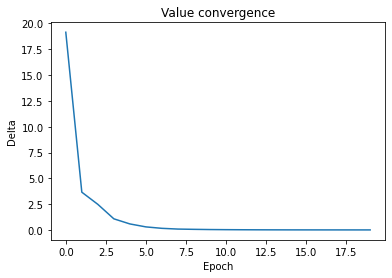

The policy iteration and value iteration both reached the same optimal policy.


In [9]:
# Compute optimal value function
Policy = np.zeros((world.state_size, world.action_size))

threshold = 0.001
gamma = 0.9
V, Policy, epochs = world.policy_iteration(Policy, discount=gamma, threshold=threshold)
optimal_policy, optimal_V, epochs = world.value_iteration(discount=gamma, threshold=threshold)

# Plot of optimal value and policy functions
# world.draw_deterministic_policy_grid((Policy, optimal_policy), titles=('Policy iteration', 'Value iteration'), n_columns=1, n_lines=2)
# world.draw_value_grid((V, optimal_V), titles=('Policy iteration', 'Value iteration'), n_columns=1, n_lines=2)
world.draw_delta_history()

if np.all(optimal_policy == Policy):
    print("The policy iteration and value iteration both reached the same optimal policy.")

4. Briefly discuss how the value of your γ and p have influenced the optimal value function
and optimal policy in your personal Grid World. In particular, you may investigate the
effect of having a value of p < 0.25, p = 0.25 or p > 0.25, and similarly γ < 0.5 or γ > 0.5.

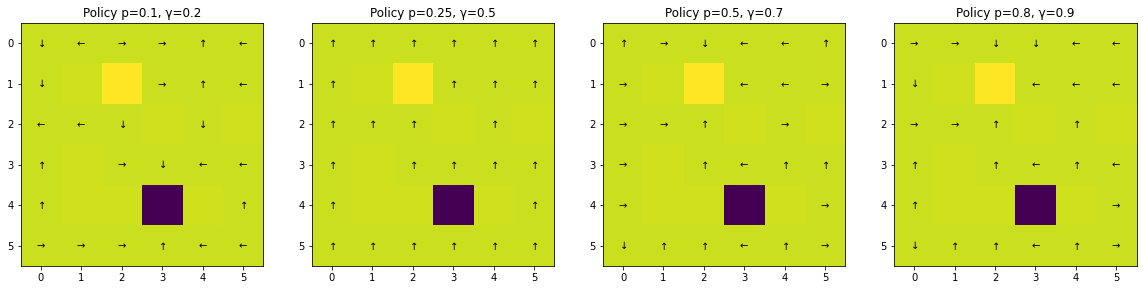

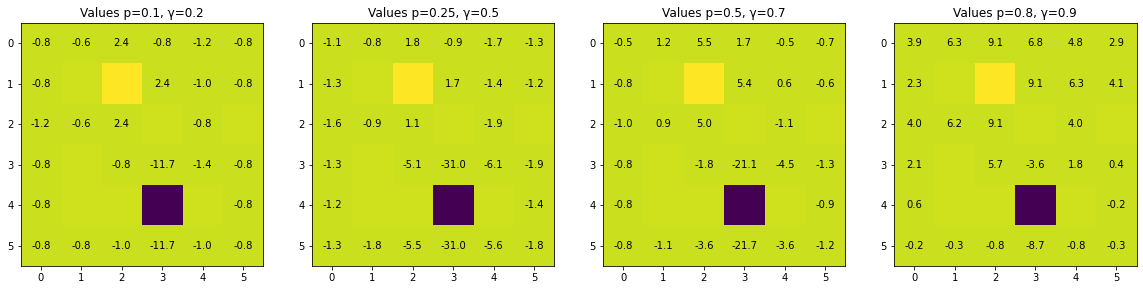

In [10]:

p = [0.1, 0.25, 0.5, 0.8]
gamma = [0.2, 0.5, 0.7, 0.9]
threshold = 0.0001

policies = []
values = []

pol_titles = []
val_titles = []

for prob, discount in zip(p, gamma):
    world = DP_Policy_World(absorbing_locs=absorbing_locs, special_rewards=special_rewards, p_transition=prob)
    optimal_policy, optimal_V, epochs = world.value_iteration(discount=discount, threshold=threshold)

    policies.append(optimal_policy)
    values.append(optimal_V)

    pol_titles.append('Policy p={}, γ={}'.format(prob, discount))
    val_titles.append('Values p={}, γ={}'.format(prob, discount))

world.draw_deterministic_policy_grid(policies, pol_titles, n_columns=1, n_lines=len(policies))
world.draw_value_grid(values, val_titles, n_columns=1, n_lines=len(values))

### c. Monte Carlo RL (15 pts)

1. Estimate the optimal value function using Monte Carlo (MC) reinforcement learning. Briefly
state how you solved the problem, including any parameters that you set or assumptions
you made

In [ ]:
class MC_World(NewGridWorld):
    def __init__(self,
            absorbing_locs=None,
            special_rewards=None,
            p_transition=0.45,
            use_first_visit=True,
            use_epsilon_greedy=True):
        super(self.__class__, self).__init__(absorbing_locs, special_rewards, p_transition)

        self.use_first_visit = use_first_visit
        self.use_epsilon_greedy = use_epsilon_greedy

    def mc_onpolicy_control(self, discount=0.45, epsilon=0.1, episode_total=2, batch=1, alpha=0.001):
        """ On-policy epsilon-greedy first-visit MC control algorithm (197/234) """
        episode_num = 0

        Q = np.zeros((self.state_size, self.action_size))
        V = np.zeros(self.state_size)
        Returns = [[[] for i in range(self.action_size)] for i in range(self.state_size)]
        soft_policy = np.zeros((self.state_size, self.action_size))

        while episode_num <= episode_total:
            # Generate episode and trace using policy
            current_trace = self.run_episode(soft_policy)
            episode_num += 1

            # state_a_tracker = [[[] for i in range(self.action_size)] for i in range(self.state_size)]
            state_a_tracker = np.zeros((self.state_size, self.action_size))
            for state, action, reward in current_trace:
                if self.use_first_visit and (state_a_tracker[state, action] > 0):
                    continue
                state_a_tracker[state, action] += 1
                G = reward
                Returns[state][action].append(G)

                Q[state, action] = self.get_discounted_reward(Returns[state][action], discount)

            for state, action, reward in current_trace:
                a_optimal = np.argmax(Q[state, :])

                for a in range(self.action_size):
                    if a_optimal == a:
                        soft_policy[state, action] = 1 - epsilon + (epsilon/self.action_size)
                    else:
                        soft_policy[state, action] = epsilon / self.action_size

            V = self.mc_policy_evaluation(soft_policy, V, discount, batch, alpha)

        return soft_policy, V

    def mc_policy_evaluation(self, Policy, V, discount=0.9, batch=1, alpha=0.001):
        """ Estimate optimal value function of an unknown MDP """
        traces = []
        episode_num = 0
        Returns = [[] for i in range(self.state_size)]

        Vnew = np.copy(V)

        current_trace = self.run_episode(Policy)
        # R_episode = self.get_discounted_reward(R_trace, discount)

        for b in range(batch):
            episode_num += 1
            # alpha = 1 / epoch
            state_tracker = np.zeros(self.state_size)

            current_trace = self.run_episode(Policy)

            for state, action, reward in current_trace:
                if self.use_first_visit and (state_tracker[state] > 0):
                    continue
                state_tracker[state] += 1
                Returns[state].append(reward)
                R_t = self.get_discounted_reward(Returns[state], discount)
                V[state] += alpha * (R_t - V[state])

        return V

    # def update_policy(self, policy, V):
    #     """ Update policy with new value. Condensed version from DP section """
        
    #     # Policy iteration
    #     for state_idx in range(policy.shape[0]):
    #         # If not an absorbing state
    #         if not(self.absorbing[0,state_idx]):
    #             # Compute Q value
    #             Q = np.zeros(4) # Initialise with value 0
    #             for state_idx_prime in range(policy.shape[0]):
    #                 current_return = R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime]
    #                 Q += T[state_idx_prime,state_idx,:] * current_return
    #             # Compute corresponding policy
    #             new_policy = np.zeros(4)
    #             new_policy[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
    #             policy[state_idx] = new_policy

    #     return policy

    def get_discounted_reward(self, R_trace, discount):
        """ Calculate the total discounted reward """
        R_discounted = 0
        for i, R in enumerate(R_trace[::-1]):
            R_discounted += pow(discount, (i+1))
        return R_discounted

    def run_episode(self, Policy):
        """ Run an episode from the start state to a terminal state """
        # Initialise state in random valid part of Grid
        current_state = self.get_random_start()
        # old_state = current_state       # keep track of old state in case agent gets stuck

        T = self.get_transition_matrix()
        R = self.get_reward_matrix()

        R_trace = []
        trace = []          # For ease of retrieval, append tuple (state, action, reward)

        # Take action, go to next state and get reward
        while not(self.absorbing[0, current_state]):
            # Check for uniform action probability (if all actions have same prob)
            if np.all(Policy[current_state, :] == Policy[current_state, 0]):
                desired_action = np.random.randint(0, len(Policy[current_state, :]))
            else:
                desired_action = np.argmax(Policy[current_state, :])
            action = self.choose_action(current_state, desired_action, T)

            # Get next state & reward
            post_state = self.neighbors[current_state, action]
            post_state = int(post_state)

            R_current = R[post_state, current_state, action]

            # Log
            R_trace.append(R_current)
            trace.append((current_state, action, R_current))

            # Update current state
            current_state = post_state
            # Break out if agent is stuck
            # if current_state == old_state:
            #     break
            # Update old state
            # old_state = current_state
                
        return trace

    def get_random_start(self):
        # Only use valid state locations
        start = np.random.randint(0, len(self.locs))
        if start in self.absorbing:
            start = start - 1
        return start

    def choose_action(self, current_state, desired_action, T):
        # Get all the next states possible for this state and action
        possible_post_states = np.where(T[:, current_state, desired_action] > 0)
        possible_post_states = possible_post_states[0]
        # Remove current state from possible post states
        # ACTUALLY Don't do this in case the action is taking you to a wall
        # if current_state in possible_post_states:
        #     current_state_idx = list(possible_post_states).index(current_state)
        #     possible_post_states = np.delete(possible_post_states, current_state_idx)

        possible_transition_probs = [T[state, current_state, desired_action] for state in possible_post_states]

        # If probability does not sum to 1, scale
        if np.sum(possible_transition_probs) < 1:
            scaling_factor = 1 / np.sum(possible_transition_probs) 
            possible_transition_probs = [prob * scaling_factor for prob in possible_transition_probs]

        # Randomly choose states based on transition probabilities
        state_chosen = np.random.choice(a=possible_post_states, p=possible_transition_probs)
        action_chosen = self.states_to_direction(prior=current_state, post=state_chosen)
        return action_chosen

In [18]:
######## MC implementation ########
p = 0.45
gamma = 0.55
epsilon = 0.1
alpha = 0.001

world = MC_World(absorbing_locs, special_rewards, p, use_first_visit=True)
# Policy = np.zeros((world.state_size, world.action_size))

soft_policy, V = world.mc_onpolicy_control(gamma, epsilon, episode_total=20, batch=1, alpha=alpha)

[(16, 2, -1.0),
 (16, 2, -1.0),
 (16, 1, -1.0),
 (17, 1, -1.0),
 (18, 3, -1.0),
 (17, 0, -1.0),
 (17, 1, -1.0),
 (18, 2, -1.0),
 (18, 3, -1.0),
 (17, 1, -1.0),
 (18, 2, -1.0),
 (18, 2, -1.0),
 (18, 1, -1.0),
 (19, 3, -1.0),
 (18, 2, -1.0),
 (18, 2, -1.0),
 (18, 3, -1.0),
 (17, 0, -1.0),
 (17, 1, -1.0),
 (18, 3, -1.0),
 (17, 1, -1.0),
 (18, 2, -1.0),
 (18, 1, -1.0),
 (19, 0, -1.0),
 (19, 3, -1.0),
 (18, 2, -1.0),
 (18, 3, -1.0),
 (17, 0, -1.0),
 (17, 3, -1.0),
 (16, 3, -1.0),
 (16, 0, -1.0),
 (13, 2, -1.0),
 (16, 1, -1.0),
 (17, 3, -1.0),
 (16, 1, -1.0),
 (17, 0, -1.0),
 (17, 1, -1.0),
 (18, 3, -1.0),
 (17, 0, -1.0),
 (17, 0, -1.0),
 (17, 1, -1.0),
 (18, 0, -1.0),
 (14, 2, -1.0),
 (18, 1, -1.0),
 (19, 3, -1.0),
 (18, 3, -1.0),
 (17, 1, -1.0),
 (18, 3, -1.0),
 (17, 3, -1.0),
 (16, 2, -1.0),
 (16, 3, -1.0),
 (16, 1, -1.0),
 (17, 1, -1.0),
 (18, 2, -1.0),
 (18, 3, -1.0),
 (17, 1, -1.0),
 (18, 2, -1.0),
 (18, 1, -1.0),
 (19, 3, -1.0),
 (18, 3, -1.0),
 (17, 1, -1.0),
 (18, 3, -1.0),
 (17, 3,

In [123]:
# Implement MC to get optimal value. 
# Initialise the Policy as epsilon greedy and improve on each episode
p = 0.45
gamma = 0.55

world = MC_World(absorbing_locs, special_rewards, p, use_first_visit=True)

epsilon = 0.1
alpha = 0.1
V_optimal, Policy_optimal = world.mc_onpolicy_control(epsilon)

KeyboardInterrupt: 

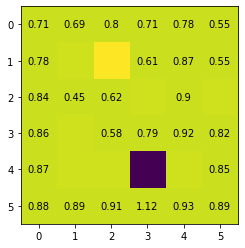

array([0.71027867, 0.69309395, 0.80017474, 0.70513096, 0.78469636,
       0.55016031, 0.78338115, 0.        , 0.60925931, 0.873937  ,
       0.55418261, 0.84378005, 0.44756432, 0.6189935 , 0.90329028,
       0.8622459 , 0.58038967, 0.79035019, 0.91824472, 0.81673158,
       0.87358837, 0.        , 0.8509061 , 0.87705906, 0.8852484 ,
       0.90741161, 1.11675245, 0.93336625, 0.88793478])

In [79]:
world.draw_value(V_optimal)
V_optimal

In [ ]:
FOR SARSA GET NP.ARGMAX for POLICY

CHECK MEAN AND STANDARD DEVIATION FOR PERFORMANCE